In [29]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

Populating the interactive namespace from numpy and matplotlib


In [33]:
def ABC(priorSampler, likelihoodSimulator, summaryStatistics, epsilon, data, n): # epsilon is the number
    # data is a numpy.array (format), each element is one observation 
    # priorSampler and likelihoodSimulator return numpy.arrays, each element is a random variable
    # summaryStatistics returns a 1-dim array
    
    # priorSampler - a function taking one argument: n - the desired length of the sample, it returns an np.array
    # likelihoodSimulator - a function taking two argument: the desired number of observations and the current parameter, it returns an np.array 
    # summaryStatistics - a function taking one argument - data, returns a 1-dim array
    # epsilon - currently a number, not percentage,
    # data - an array
    # n - number of simulations (not the number of accepted samples)
    
    prior_sample = priorSampler(n)
    stat = summaryStatistics(data)
    theta_generated = []
    accepted = []
    output_list = []
    
    for i in range(n):
        # data is currently an array of shape (data_len,)
        simulated_data = likelihoodSimulator(shape(data)[0], prior_sample[i])
        
        temporary_stat = summaryStatistics(simulated_data)
        # in the line below we are comparing sum of squares of the elements of temporary_stat - stat
        if np.sum(np.square(np.subtract(temporary_stat, stat))) < epsilon*epsilon: # check here!
            accept = 1
        else: accept = 0
            
        output_dict = {'accept': accept, 'z':simulated_data, 'theta': prior_sample[i]} # added theta
        # seems more reasonable to add the theta at the end of function ...
        output_list.append(output_dict)
    
    df = pd.DataFrame(output_list)
    return df

## Normal example

In [216]:
######
# set up for the normal ABC example
######

prior_mean = -3.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

-0.128509233387 is posterior mean
0.00998890122087 is posterior std dev


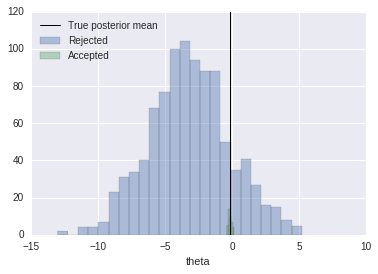

In [225]:
######
# run ABC for the normal example
######

df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.2, data , 1000)

######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = False, label=accept_legend_map[accept]) #norm_hist =True,


plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc.pdf')